# Enzyme analysis for RhizCG 2013

## Set Variables

In [1]:
workDir = '/home/bryan/RhizCG/figures/'
fullData = '/home/bryan/RhizCG/data/MiSeq_amplicon/PlotData.txt'

#Init

In [2]:
%load_ext rpy2.ipython

In [29]:
%%R
library(lme4)
library(lmerTest)
library(ggplot2)
library(dplyr)
library(pbkrtest)
library(gridExtra)
library(multcomp)
library(vegan)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: permute

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: lattice

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: This is vegan 2.4-0

  res = super(Function, self).__call__(*new_args, **new_kwargs)


### Read plant master table 

In [4]:
%%R -i fullData -i workDir
setwd(workDir)
Master = read.table(fullData, header = TRUE)
Master$Rep = as.factor(Master$Rep)
colnames(Master)

 [1] "Unique"             "PlotID"             "Plant"             
 [4] "Plot"               "Treatment"          "Rep"               
 [7] "DAP"                "Sampling"           "PlantSample"       
[10] "Type"               "Grass_Broad"        "Status"            
[13] "Subfamily"          "Symbol_class"       "Plant_num"         
[16] "Leaf_AreaBiomass_g" "Biomass_T"          "Biomass_P"         
[19] "Leaf_Area_cm2"      "SLA"                "Leaf_N"            
[22] "Leaf_C"             "LeafC_N"            "LNa"               
[25] "Plant_N"            "Plant_C"            "Plant_CN"          
[28] "d15N"               "tN_p"               "BX_act"            
[31] "CB_act"             "LAP_act"            "NAG_act"           
[34] "soil_dw"            "BX_activity_g"      "CB_activity_g"     
[37] "LAP_activity_g"     "NAG_activity_g"     "BX_barefactor"     
[40] "CB_barefactor"      "LAP_barefactor"     "NAG_barefactor"    
[43] "BX_dif"             "CB_dif"             "

# Graph enzyme activity in bare vs rhizosphere soils

In [5]:
%%R
e_sel = !is.na(Master$BX_dif)
Enz = Master[e_sel,]


In [6]:
%%R
#calculate means of Bare soil vs Planted treatments
Enz$Planted = as.factor(ifelse(Enz$Plant == "BARE", "Bare Soil", "Rhizosphere"))

by_treat = group_by(Enz, Planted, Treatment)
Emeans = summarize(by_treat,
              N = length(BX_activity_g),
                   bx.m = mean(BX_activity_g),
                   bx.se = sd(BX_activity_g)/sqrt(length(BX_activity_g)),
                  cb.m = mean(CB_activity_g),
                   cb.se = sd(CB_activity_g)/sqrt(length(CB_activity_g)),
                  lap.m = mean(LAP_activity_g),
                   lap.se = sd(LAP_activity_g)/sqrt(length(LAP_activity_g)),
                    nag.m = mean(NAG_activity_g),
                  nag.se = sd(NAG_activity_g)/sqrt(length(NAG_activity_g)))
head(Emeans)

Source: local data frame [4 x 11]
Groups: Planted [2]

      Planted Treatment     N     bx.m     bx.se     cb.m     cb.se    lap.m
       <fctr>    <fctr> <int>    <dbl>     <dbl>    <dbl>     <dbl>    <dbl>
1   Bare Soil      Nneg    32 15.17175 0.6498354 14.29288 0.5461105 126.6001
2   Bare Soil      Npos    32 14.82994 0.7252128 13.78256 0.5471938 134.4734
3 Rhizosphere      Nneg    88 22.32679 0.5840031 20.95171 0.5609904 150.1426
4 Rhizosphere      Npos    88 24.84942 0.6868409 23.96746 0.6087010 158.9072
# ... with 3 more variables: lap.se <dbl>, nag.m <dbl>, nag.se <dbl>


In [7]:
%%R -w 1000 -h 300

P1 = ggplot(Emeans, aes(x = Treatment, y = bx.m, fill = Treatment)) +
        scale_fill_manual(values = c("grey","black"))+
        geom_bar(stat = "identity") + 
        geom_errorbar(data = Emeans, aes(y = bx.m,
                  ymin = bx.m - bx.se, ymax = bx.m + bx.se), width = 0.4)+
        ylab("nmol/g/s/hr")+
        ggtitle("BX") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        facet_grid(. ~ Planted)+
        theme(legend.position="none")
        

P2 = ggplot(Emeans, aes(x = Treatment, y = cb.m, fill = Treatment)) +
        scale_fill_manual(values = c("grey","black"))+
        geom_bar(stat = "identity") + 
        geom_errorbar(data = Emeans, aes(y = cb.m,
                  ymin = cb.m - cb.se, ymax = cb.m + cb.se), width = 0.4)+
        ylab("nmol/g/s/hr")+
        ggtitle("CB") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        facet_grid(. ~ Planted)+
        theme(legend.position="none")

P3 = ggplot(Emeans, aes(x = Treatment, y = lap.m, fill = Treatment)) +
        scale_fill_manual(values = c("grey","black"))+
        geom_bar(stat = "identity") + 
        geom_errorbar(data = Emeans, aes(y = lap.m,
                  ymin = lap.m - lap.se, ymax = lap.m + lap.se),
                   colour = 'black', width = 0.4) +
        
        ylab("nmol/g/s/hr")+
        ggtitle("LAP") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        theme(axis.title.y = element_blank()) +
        facet_grid(. ~ Planted)+
        theme(legend.position="none")

P4 = ggplot(Emeans, aes(x = Treatment, y = nag.m, fill = Treatment))  +
        scale_fill_manual(values = c("grey","black"))+
        geom_bar(stat = "identity") + 
        geom_errorbar(data = Emeans, aes(y = nag.m,
                  ymin = nag.m - nag.se, ymax = nag.m + nag.se),
                   colour = 'black', width = 0.4) +
        theme(axis.title.x = element_blank())+ 
        ylab("nmol/g/s/hr") +
        ggtitle("NAG") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        facet_grid(. ~ Planted)+
        theme(legend.position="none")


#print to file
pdf(file = "enzyme_rhizosphere_xTreatment_presversion.pdf", height = 3, width = 5)
P2 %>% print
dev.off

function (which = dev.cur()) 
{
    if (which == 1) 
        stop("cannot shut down device 1 (the null device)")
    .External(C_devoff, as.integer(which))
    dev.cur()
}
<bytecode: 0xa5c20d8>
<environment: namespace:grDevices>


## Model

Notes: Rep has small random effect for BX, CB and NAG once nested Rep:Plant term is added.  However, REP contains considerable informatiomn for LAP.  Also possible to use Plot variable as random effect to avoid confusion. 

Residuals checked.  With exception of few outliers of predicted values residuals are normally and evenly distributed.   

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF   DenDF F.value    Pr(>F)    
Planted           224.464 224.464     1  49.291 15.0614 0.0003094 ***
Treatment          55.804  55.804     1 146.376  3.7444 0.0549129 .  
Planted:Treatment  96.272  96.272     1 146.376  6.4598 0.0120750 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
             Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
PlantedTreat 502.11  167.37     3 138.76   11.23 1.212e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


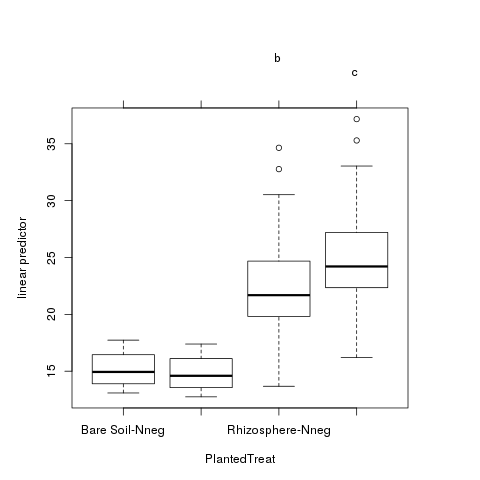

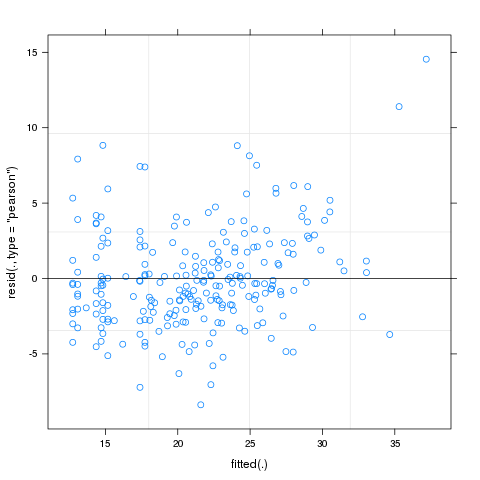

In [8]:
%%R

Enz$PlantedTreat = paste(Enz$Planted, Enz$Treatment, sep = "-")
m = lmer(BX_activity_g ~ Planted + Treatment + Planted:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m1 = lmer(BX_activity_g ~ PlantedTreat + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m1, ddf="Kenward-Roger", type=3) %>% print
        m1.lsm = lsmeans(m1)
        m1.glht = glht(m1, linfct = mcp(PlantedTreat = "Tukey"))
        summary(m1.glht)
m1.cld = cld(m1.glht, level = 0.05)
old.par <- par(mai=c(1,1,1.5,1), no.readonly = TRUE)
plot(m1.cld)
        

plot(m)

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                   Sum Sq Mean Sq NumDF   DenDF F.value    Pr(>F)    
Planted           279.861 279.861     1  42.544 20.0037 5.667e-05 ***
Treatment          73.652  73.652     1 146.614  5.2644  0.023185 *  
Planted:Treatment 145.883 145.883     1 146.614 10.4274  0.001532 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
             Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
PlantedTreat 677.69   225.9     3 129.89  16.146 5.589e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


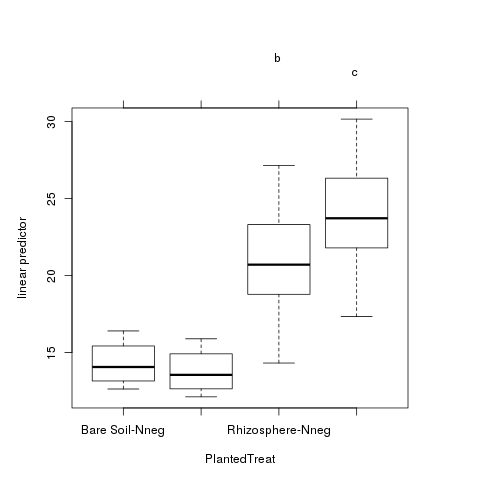

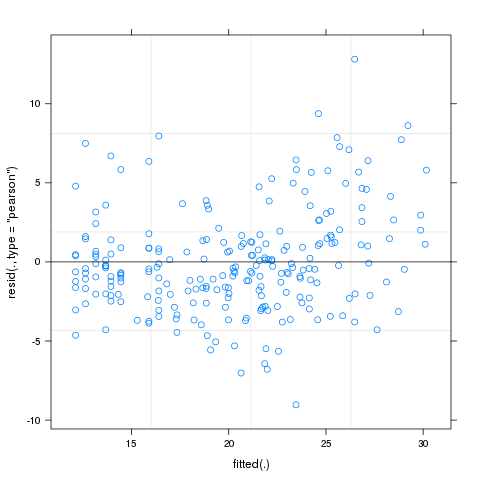

In [9]:
%%R

Enz$PlantedTreat = paste(Enz$Planted, Enz$Treatment, sep = "-")
m = lmer(CB_activity_g ~ Planted + Treatment + Planted:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m1 = lmer(CB_activity_g ~ PlantedTreat + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m1, ddf="Kenward-Roger", type=3) %>% print
        m1.lsm = lsmeans(m1)
        m1.glht = glht(m1, linfct = mcp(PlantedTreat = "Tukey"))
        summary(m1.glht)
m1.cld = cld(m1.glht, level = 0.05)
old.par <- par(mai=c(1,1,1.5,1), no.readonly = TRUE)
plot(m1.cld)
plot(m)

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq Mean Sq NumDF   DenDF F.value   Pr(>F)   
Planted           1958.8  1958.8     1  46.527  4.6462 0.036328 * 
Treatment         3248.0  3248.0     1 146.501  7.7042 0.006229 **
Planted:Treatment    9.3     9.3     1 146.501  0.0221 0.881998   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
             Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)   
PlantedTreat 6275.1  2091.7     3 135.34  4.9614 0.002679 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


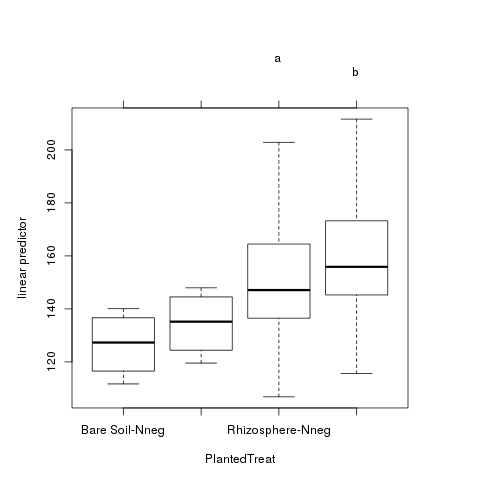

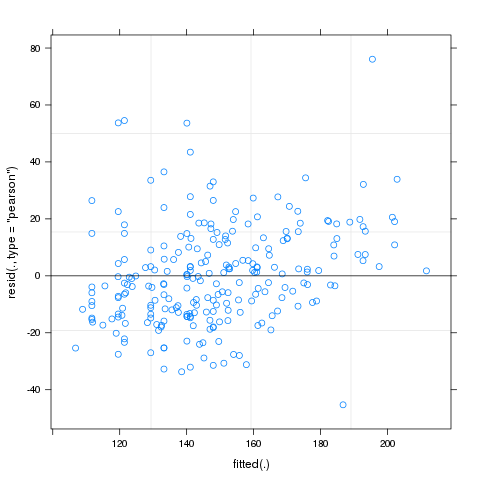

In [10]:
%%R

Enz$PlantedTreat = paste(Enz$Planted, Enz$Treatment, sep = "-")
m = lmer(LAP_activity_g ~ Planted + Treatment + Planted:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m1 = lmer(LAP_activity_g ~ PlantedTreat + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m1, ddf="Kenward-Roger", type=3) %>% print
        m1.lsm = lsmeans(m1)
        m1.glht = glht(m1, linfct = mcp(PlantedTreat = "Tukey"))
       # summary(m1.glht)
m1.cld = cld(m1.glht, level = 0.05)
old.par <- par(mai=c(1,1,1.5,1), no.readonly = TRUE)
plot(m1.cld)
plot(m)

Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq Mean Sq NumDF   DenDF F.value   Pr(>F)   
Planted           59.651  59.651     1  43.815  9.2555 0.003958 **
Treatment          8.259   8.259     1 146.528  1.2815 0.259465   
Planted:Treatment 41.918  41.918     1 146.528  6.5041 0.011789 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
             Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
PlantedTreat 144.65  48.216     3 131.69  7.4812 0.0001158 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


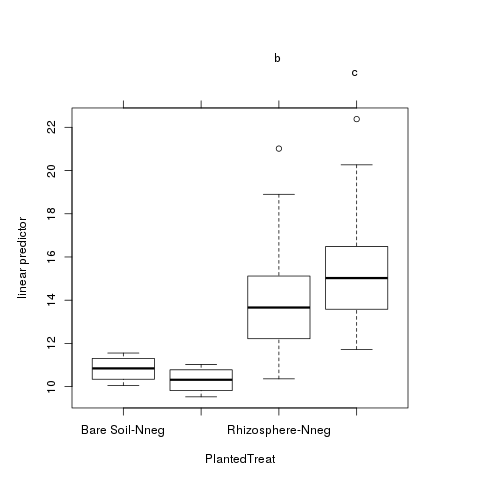

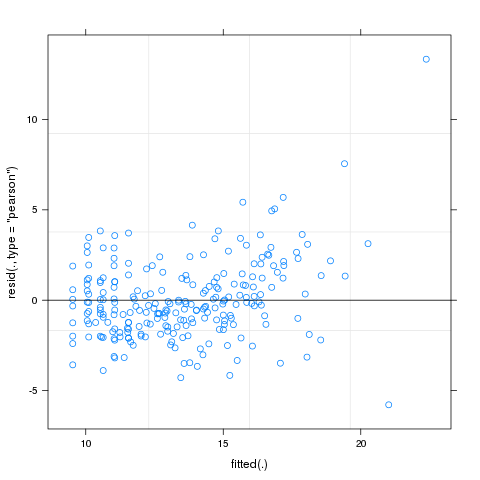

In [11]:
%%R

Enz$PlantedTreat = paste(Enz$Planted, Enz$Treatment, sep = "-")
m = lmer(NAG_activity_g ~ Planted + Treatment + Planted:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m1 = lmer(NAG_activity_g ~ PlantedTreat + (1|Rep) + (1|Rep:Plant), 
          data = Enz)
         #summary(m1) %>% print
         anova(m1, ddf="Kenward-Roger", type=3) %>% print
        m1.lsm = lsmeans(m1)
        m1.glht = glht(m1, linfct = mcp(PlantedTreat = "Tukey"))
        summary(m1.glht)
m1.cld = cld(m1.glht, level = 0.05)
old.par <- par(mai=c(1,1,1.5,1), no.readonly = TRUE)
plot(m1.cld)
plot(m)

# Model rhizosphere effect

## First with just treatment effects

In [12]:
%%R
PlantEnz = Enz[Enz$Planted == "Rhizosphere",]
PlantEnz$Rep = as.factor(PlantEnz$Rep)
PlantEnz$PlantTreat = as.factor(paste(PlantEnz$Plant, PlantEnz$Treatment, sep = "-"))

### BX

In [13]:
%%R
colnames(PlantEnz)

 [1] "Unique"             "PlotID"             "Plant"             
 [4] "Plot"               "Treatment"          "Rep"               
 [7] "DAP"                "Sampling"           "PlantSample"       
[10] "Type"               "Grass_Broad"        "Status"            
[13] "Subfamily"          "Symbol_class"       "Plant_num"         
[16] "Leaf_AreaBiomass_g" "Biomass_T"          "Biomass_P"         
[19] "Leaf_Area_cm2"      "SLA"                "Leaf_N"            
[22] "Leaf_C"             "LeafC_N"            "LNa"               
[25] "Plant_N"            "Plant_C"            "Plant_CN"          
[28] "d15N"               "tN_p"               "BX_act"            
[31] "CB_act"             "LAP_act"            "NAG_act"           
[34] "soil_dw"            "BX_activity_g"      "CB_activity_g"     
[37] "LAP_activity_g"     "NAG_activity_g"     "BX_barefactor"     
[40] "CB_barefactor"      "LAP_barefactor"     "NAG_barefactor"    
[43] "BX_dif"             "CB_dif"             "

In [14]:
%%R
m = lmer(log(BX_rel) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = PlantEnz)
         #summary(m) %>% print
        print("BX_rel") 
        anova(m, ddf="Kenward-Roger", type=3) %>% print

        


[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value    Pr(>F)    
Plant           1.42457 0.06784    21    63   2.620   0.00171 ** 
Treatment       0.91533 0.91533     1    66  35.353 1.149e-07 ***
Plant:Treatment 0.90228 0.04297    21    66   1.659   0.06183 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [15]:
%%R
m = lmer(CB_rel ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = PlantEnz)
         #summary(m1) %>% print
        print("CB_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print
        #summary(m)

        

[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                Sum Sq Mean Sq NumDF DenDF F.value    Pr(>F)    
Plant           4.1264  0.1965    21    63   1.892   0.02725 *  
Treatment       3.8665  3.8665     1    66  37.229 6.176e-08 ***
Plant:Treatment 3.3586  0.1599    21    66   1.540   0.09433 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [16]:
%%R
m = lmer(LAP_rel ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = PlantEnz)
         #summary(m) %>% print
        print("LAP_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print
            #summary(m)




[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq  Mean Sq NumDF DenDF F.value   Pr(>F)   
Plant           0.88905 0.042336    21    63 2.35551 0.004717 **
Treatment       0.00010 0.000104     1    66 0.00577 0.939659   
Plant:Treatment 0.69378 0.033037    21    66 1.83815 0.032103 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [17]:
%%R
m = lmer(log(NAG_rel) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = PlantEnz)
         #summary(m) %>% print
print("NAG_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print

        


[1] "NAG_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value    Pr(>F)    
Plant           1.91840 0.09135    21    63  2.9233 0.0005372 ***
Treatment       0.88361 0.88361     1    66 28.2758 1.343e-06 ***
Plant:Treatment 1.02657 0.04888    21    66  1.5643 0.0866635 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [18]:
%%R
data = filter(PlantEnz, NAG_rel <4)
by_treat = group_by(data, Plant, Treatment)
Emeans = summarize(by_treat,
              N = length(BX_rel),
                   bx.m = mean(BX_rel),
                   bx.se = sd(BX_rel)/sqrt(length(BX_rel)),
                  cb.m = mean(CB_rel),
                   cb.se = sd(CB_rel)/sqrt(length(CB_rel)),
                  lap.m = mean(LAP_rel),
                   lap.se = sd(LAP_rel)/sqrt(length(LAP_rel)),
                    nag.m = mean(NAG_rel),
                  nag.se = sd(NAG_rel)/sqrt(length(NAG_rel)),
                  DAY = first(DAP))
#head(Emeans)

In [19]:
%%R -w 800 -h 1000
P1 = ggplot(Emeans, aes(x = Plant, y = cb.m, fill = Treatment)) +
        geom_point(pch = 21, size = 3) + 
        geom_errorbar(data = Emeans, aes(y = bx.m,
                  ymin = bx.m - bx.se, ymax = bx.m + bx.se), width = 0.4)+
        scale_fill_manual(values = c("grey","black")) +
        ylab("Rhizosphere Effect")+
        ggtitle("BX") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        theme(legend.position="none") +
        theme(axis.text.x  = element_blank()) + 
        facet_wrap(~DAY, nrow = 1)
P2 = ggplot(Emeans, aes(x = Plant, y = lap.m, fill = Treatment)) +
        geom_point(pch = 21, size = 3) + 
        geom_errorbar(data = Emeans, aes(y = lap.m,
                  ymin = lap.m - lap.se, ymax = lap.m + lap.se), width = 0.4)+
        scale_fill_manual(values = c("grey","black")) +
        ylab("Rhizosphere Effect")+
        ggtitle("LAP") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        theme(legend.position="none") +
        theme(axis.text.x  = element_text(angle=45, vjust=0.5, size=16)) +

        facet_wrap(~DAY, nrow = 1)

P3 = ggplot(Emeans, aes(x = Plant, y = nag.m, fill = Treatment)) +
        geom_point(pch = 21, size = 3) + 
        geom_errorbar(data = Emeans, aes(y = nag.m,
                  ymin = nag.m - nag.se, ymax = nag.m + nag.se), width = 0.4)+
        scale_fill_manual(values = c("grey","black")) +
        ylab("Rhizosphere Effect")+
        ggtitle("NAG") +
        theme_bw(base_size = 16)+
        theme(axis.title.x = element_blank()) +
        theme(legend.position="none") +
        theme(axis.text.x  = element_text(angle=45, vjust=0.5, size=16)) +

        facet_wrap(~DAY, nrow = 1)

P = grid.arrange(P1, P2, P3, ncol = 1)

pdf(file = "/home/bryan/RhizCG/figures/enzymes_plant.pdf", width = 10, height = 8)
grid.arrange(P1, P2, ncol = 1)
dev.off()

png 
  2 


## Interaction between treatment and time

In [20]:
%%R
m = lmer(BX_rel~DAP*Treatment + (1|Rep) + (1|Plant), na.rm = TRUE, data = PlantEnz)
print("BX_rel")
anova(m) %>% print

m = lmer(CB_rel~DAP*Treatment + (1|Rep) + (1|Plant), na.rm = TRUE, data = PlantEnz)
print("CB_rel")
anova(m) %>% print

m = lmer(LAP_rel~DAP*Treatment + (1|Rep) + (1|Plant), na.rm = TRUE, data = PlantEnz)
print("LAP_rel")
anova(m) %>% print

data = filter(PlantEnz, NAG_rel <4)
m = lmer(NAG_rel~DAP*Treatment + (1|Rep) + (1|Plant), na.rm = TRUE, data = data)
print("NAG_rel")
anova(m) %>% print


[1] "BX_rel"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.value   Pr(>F)   
DAP           0.55317 0.55317     1    20  5.5861 0.028340 * 
Treatment     0.81328 0.81328     1   149  8.2127 0.004762 **
DAP:Treatment 0.38993 0.38993     1   149  3.9376 0.049055 * 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
DAP           0.13802 0.13802     1    20  1.1518 0.29596  
Treatment     0.76455 0.76455     1   149  6.3802 0.01258 *
DAP:Treatment 0.26466 0.26466     1   149  2.2086 0.13936  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
               Sum Sq Mean Sq NumDF DenDF F.

* Interaction for BX, LAP and NAG
* LAP is the most pronounced

In [21]:
%%R
head(Emeans)

Source: local data frame [6 x 12]
Groups: Plant [3]

   Plant Treatment     N     bx.m     bx.se     cb.m     cb.se    lap.m
  <fctr>    <fctr> <int>    <dbl>     <dbl>    <dbl>     <dbl>    <dbl>
1 75-062      Nneg     4 1.410555 0.2355612 1.491043 0.2796418 1.208871
2 75-062      Npos     4 1.731261 0.1529143 1.919034 0.1769265 1.236364
3  ABUTH      Nneg     4 1.591899 0.1777430 1.451152 0.1416835 1.043602
4  ABUTH      Npos     4 2.632162 0.3406024 2.419472 0.2616576 1.332508
5  AMAPO      Nneg     4 1.785122 0.2641789 1.718336 0.2163452 1.190163
6  AMAPO      Npos     4 1.722847 0.1405241 1.699689 0.1462254 1.211164
# ... with 4 more variables: lap.se <dbl>, nag.m <dbl>, nag.se <dbl>, DAY <int>


# Are there significant differences in rhizosphere effect between plants harvested on the same date?

* No significant differences when comparing plants harvested/measured on the same day
* Differences must be driven by either larger genetic variation captured by flowering date or
* Stochaistic variation driven by date of sampling/ batch effects

### Day 53, AMAPO and ECHCG

In [22]:
%%R
Day53 = filter(PlantEnz, DAP == 53, TRUE)
List = c("BX_rel", "CB_rel", "LAP_rel", "NAG_rel")

for (i in List) {
m = lmer(get(i) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = Day53)
        print(paste(i))
         #summary(m) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
    }

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
Plant           0.073460 0.073460     1     3 1.15698 0.3609
Treatment       0.056902 0.056902     1     6 0.89619 0.3804
Plant:Treatment 0.131835 0.131835     1     6 2.07637 0.1997
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.003809 0.003809     1     3  0.1275 0.74470  
Treatment       0.142139 0.142139     1     6  4.7577 0.07194 .
Plant:Treatment 0.171649 0.171649     1     6  5.7454 0.05352 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)  
Plant           0.037647 0.037647   

## Day 57 ABUTH and GLYMA

In [23]:
%%R
DaySub = filter(PlantEnz, DAP == 57, TRUE)
List = c("BX_rel", "CB_rel", "LAP_rel", "NAG_rel")

for (i in List) {
m = lmer(get(i) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = DaySub)
        print(paste(i))
         #summary(m) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
    }

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.21960 0.21960     1     3  1.2336 0.34772  
Treatment       1.55477 1.55477     1     6  8.7343 0.02543 *
Plant:Treatment 0.69492 0.69492     1     6  3.9039 0.09558 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.04844 0.04844     1     3  0.3327 0.60449  
Treatment       1.14673 1.14673     1     6  7.8764 0.03090 *
Plant:Treatment 0.74958 0.74958     1     6  5.1485 0.06375 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq Nu

## Day 72 75-062,  ERATE, H99,  Il14H,  MS71  

In [24]:
%%R
DaySub = filter(PlantEnz, DAP == 72, TRUE)
List = c("BX_rel", "CB_rel", "LAP_rel", "NAG_rel")

for (i in List) {
m = lmer(get(i) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = DaySub)
        print(paste(i))
         #summary(m) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
    }

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value   Pr(>F)    
Plant           0.12303 0.03076     4    12   1.219   0.3532    
Treatment       1.09432 1.09432     1    15  43.387 8.63e-06 ***
Plant:Treatment 0.06353 0.01588     4    15   0.630   0.6488    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value    Pr(>F)    
Plant           0.12231 0.03058     4    12   0.475    0.7537    
Treatment       2.42951 2.42951     1    15  37.722 1.885e-05 ***
Plant:Treatment 0.24033 0.06008     4    15   0.933    0.4713    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
        

## Day 79 B73 B97 Hp301 Oh7B 

In [25]:
%%R
DaySub = filter(PlantEnz, DAP == 79, TRUE)
List = c("BX_rel", "CB_rel", "LAP_rel", "NAG_rel")

for (i in List) {
 m = lmer(get(i) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
           data = DaySub)
 
        print(paste(i))
         #summary(m) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
    }

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.006039 0.002013     3     9  0.0763 0.97121  
Treatment       0.208854 0.208854     1    12  7.9201 0.01562 *
Plant:Treatment 0.145302 0.048434     3    12  1.8367 0.19421  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value   Pr(>F)   
Plant           0.23506 0.07835     3     9  0.8031 0.522966   
Treatment       1.06034 1.06034     1    12 10.8683 0.006379 **
Plant:Treatment 0.04824 0.01608     3    12  0.1648 0.918007   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Su

## Day 84 HELAN SORBI SORSUD

In [26]:
%%R
DaySub = filter(PlantEnz, DAP == 84, TRUE)
List = c("BX_rel", "CB_rel", "LAP_rel", "NAG_rel")

for (i in List) {
m = lmer(get(i) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = DaySub)
        print(paste(i))
         #summary(m) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
    }

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
Plant           0.003106 0.001553     2     6 0.02471 0.9757
Treatment       0.024707 0.024707     1     9 0.39317 0.5462
Plant:Treatment 0.280181 0.140091     2     9 2.22926 0.1635
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value Pr(>F)
Plant           0.120483 0.060241     2     6 0.56851 0.5942
Treatment       0.050359 0.050359     1     9 0.47525 0.5080
Plant:Treatment 0.266413 0.133207     2     9 1.25710 0.3300
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.033479 0.016740     2     6  1.3018 0.33916  
Treatment       0.065646 0.065646     1     9  5.1

## Day 88 ELCOR  Ki3  Mo18  Tx303  

In [27]:
%%R
DaySub = filter(PlantEnz, DAP == 88, TRUE)
List = c("BX_rel", "CB_rel", "LAP_rel", "NAG_rel")

for (i in List) {
m = lmer(get(i) ~ Plant + Treatment + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = DaySub)
        print(paste(i))
         #summary(m) %>% print
         anova(m, ddf="Kenward-Roger", type=3) %>% print
    }

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.36531 0.12177     3     9  1.3501 0.31867  
Treatment       0.40646 0.40646     1    12  4.5065 0.05525 .
Plant:Treatment 0.07618 0.02539     3    12  0.2815 0.83774  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                 Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
Plant           0.35655 0.11885     3     9  1.2198 0.35765  
Treatment       0.37667 0.37667     1    12  3.8661 0.07284 .
Plant:Treatment 0.11598 0.03866     3    12  0.3968 0.75772  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
                  Sum Sq  Mean Sq Nu

# Is N treatment effect due to fertilizer effects on plant growth or releiving N limitation in the rhizosphere

In [28]:
%%R

#filter out maize to avoid maize/annual comparison and outlier of InorganicN
data = filter(Enz, InorganicN < 45) %>% filter(Plant != "BARE" & Plant != "Maize" | Plant == "B73")

m = lmer(log(BX_rel) ~ Plant + A_Resid_logN + InorganicN + (1|Rep)  + (1|Rep:Plant), 
          data = data)
         #summary(m) %>% print
        print("BX_rel")
         anova(m, ddf="Kenward-Roger", type=3) %>% print
        

m = lmer(log(CB_rel) ~ Plant + A_Resid_logN  + InorganicN  + (1|Rep)  + (1|Rep:Plant), 
          data = data)
         #summary(m) %>% print
        print("CB_rel")
         anova(m, ddf="Kenward-Roger", type=3) %>% print       
        

m = lmer(log(LAP_rel) ~ Plant + A_Resid_logN + InorganicN + (1|Rep)  + (1|Rep:Plant), 
          data = data)
         #summary(m) %>% print
        print("LAP_rel")
         anova(m, ddf="Kenward-Roger", type=3) %>% print
        

m = lmer(log(BX_rel) ~ Plant + A_Resid_logN + InorganicN + (1|Rep)  + (1|Rep:Plant), 
          data = data)
         #summary(m) %>% print
        print("NAG_rel")
         anova(m, ddf="Kenward-Roger", type=3) %>% print
        

[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq  Mean Sq NumDF  DenDF F.value   Pr(>F)   
Plant        0.97602 0.097602    10 31.210  2.6422 0.018463 * 
A_Resid_logN 0.10631 0.106314     1 68.137  2.8781 0.094358 . 
InorganicN   0.30313 0.303132     1 69.668  8.2062 0.005513 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
              Sum Sq  Mean Sq NumDF  DenDF F.value  Pr(>F)  
Plant        0.98878 0.098878    10 31.059  2.2046 0.04496 *
A_Resid_logN 0.25150 0.251501     1 67.513  5.6076 0.02075 *
InorganicN   0.30902 0.309021     1 70.579  6.8901 0.01062 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
               Sum Sq  Mean Sq NumDF

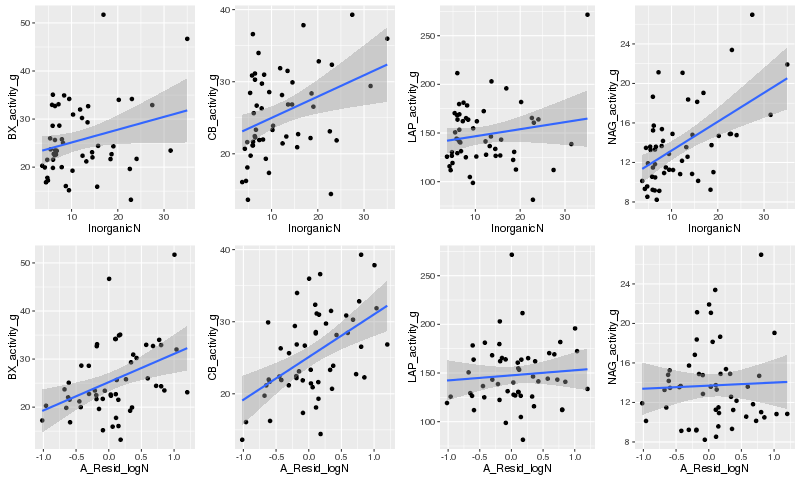

In [142]:
%%R -w 800
data = filter(Enz, Type != "Maize" & Plant != "BARE" & InorganicN < 45)
pa = ggplot(data, aes(x = InorganicN, y = BX_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")



pb = ggplot(data, aes(x = A_Resid_logN, y = BX_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")




p1a = ggplot(data, aes(x = InorganicN, y = CB_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")



p1b = ggplot(data, aes(x = A_Resid_logN, y = CB_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")


p2a = ggplot(data, aes(x = InorganicN, y = LAP_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")



p2b = ggplot(data, aes(x = A_Resid_logN, y = LAP_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")


p3a = ggplot(data, aes(x = InorganicN, y = NAG_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")



p3b = ggplot(data, aes(x = A_Resid_logN, y = NAG_activity_g)) +
geom_point() + 
stat_smooth(method = "lm")


grid.arrange(pa, p1a,p2a, p3a, pb, p1b, p2b, p3b,  ncol = 4)

# Resume here to determine if plant differences in growth characteristics drive enzyme patterns 

## Use same functional variables as CorMLPE script

### Annuals and B73

In [33]:
%%R
sub = filter(Enz, Plant != "BARE" & Treatment == "Nneg")
sub = filter(sub, Type != "Maize" | Plant == "B73")
dim(sub)
sub$Plant

 [1] FAGES  FAGES  FAGES  FAGES  AMAPO  ECHCG  AMAPO  ECHCG  AMAPO  ECHCG 
[11] ECHCG  AMAPO  GLYMA  ABUTH  GLYMA  ABUTH  GLYMA  ABUTH  GLYMA  ABUTH 
[21] SETFA  SETFA  SETFA  SETFA  ERATE  ERATE  ERATE  ERATE  B73    B73   
[31] B73    B73    SORSUD SORBI  HELAN  HELAN  SORSUD SORBI  HELAN  SORBI 
[41] SORSUD SORSUD HELAN  SORBI  ELCOR  ELCOR  ELCOR  ELCOR 
12 Levels: ABUTH AMAPO B73 ECHCG ELCOR ERATE FAGES GLYMA HELAN SETFA ... SORSUD


In [42]:
%%R
#add growing degree days
DAP = c(36, 53, 57, 61, 72, 79, 84, 88)
GDD = c(795.1, 1089.4, 1136.8, 1199.5, 1394.3, 1512.4, 1573.8, 1625.6)
M_GDD = cbind(DAP, GDD) %>% as.data.frame
M_GDD

Plant = c("ERATE", "HELAN", "B73", "FAGES", "AMAPO", "SORSUD", "SORBI", 
          "ELCOR", "ECHCG", "ABUTH", "SETFA", "GLYMA", "MS71", "Mo18", "Il14H", "Tx303", "Oh7B",
         "B97", "Hp301", "75-062", "Ki3", "H99")
SeedSize_mg = c(.0035, 90, 333, 38, .49, 10.7, 32.39,
               3.2, 1.58, 9.6, 1.8, 174, .264, .224, 0.219, 0.279, 0.207,
               0.240, 0.0869, 0.222, 0.228, 0.231)
SS = cbind(Plant, SeedSize_mg) %>% as.data.frame
head(SS) %>% print
SS$SeedSize_mg = SS$SeedSize_mg %>% as.character %>% as.numeric
(SS)

sd = left_join(sub, SS, by = "Plant")
str(sd) %>% print

   Plant SeedSize_mg
1  ERATE      0.0035
2  HELAN          90
3    B73         333
4  FAGES          38
5  AMAPO        0.49
6 SORSUD        10.7
'data.frame':	48 obs. of  67 variables:
 $ Unique            : Factor w/ 240 levels "sample1-1.06_Nneg",..: 3 7 11 13 19 21 25 27 29 33 ...
 $ PlotID            : Factor w/ 184 levels "1.03_Nneg","1.03_Npos",..: 41 81 105 175 9 37 57 59 99 125 ...
 $ Plant             : chr  "FAGES" "FAGES" "FAGES" "FAGES" ...
 $ Plot              : num  1.27 2.23 3.08 4.24 1.08 1.24 2.08 2.1 3.05 3.2 ...
 $ Treatment         : Factor w/ 2 levels "Nneg","Npos": 1 1 1 1 1 1 1 1 1 1 ...
 $ Rep               : Factor w/ 4 levels "1","2","3","4": 1 2 3 4 1 1 2 2 3 3 ...
 $ DAP               : int  36 36 36 36 53 53 53 53 53 53 ...
 $ Sampling          : Factor w/ 8 levels "sample1","sample2",..: 1 1 1 1 2 2 2 2 2 2 ...
 $ PlantSample       : Factor w/ 30 levels "75-062_sample5",..: 17 17 17 17 3 14 3 14 3 14 ...
 $ Type              : Factor w/ 6 levels "BARE","

In [37]:
%%R
# PCA of all samples


#sd = left_join(sd, M_GDD, by = "DAP")

#  fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = sd, 
#                  na.action = na.exclude, center = TRUE, scale = TRUE)

# summary(fit) %>% print
# fit$rotation %>% print
# biplot(fit)


NULL


In [43]:
%%R

# rDA of enzyme and plant traits
sd$DAP = sd$DAP %>% as.character %>% as.numeric
str(sd)
sd$logSeedSize = log(sd$SeedSize_mg)
sd.e = sd[,c("BX_activity_g", "CB_activity_g", "LAP_activity_g", "NAG_activity_g")]
sd.p = sd[,c("DAP","A_Resid_logCN", "A_Resid_logN", "logSeedSize")]



'data.frame':	48 obs. of  67 variables:
 $ Unique            : Factor w/ 240 levels "sample1-1.06_Nneg",..: 3 7 11 13 19 21 25 27 29 33 ...
 $ PlotID            : Factor w/ 184 levels "1.03_Nneg","1.03_Npos",..: 41 81 105 175 9 37 57 59 99 125 ...
 $ Plant             : chr  "FAGES" "FAGES" "FAGES" "FAGES" ...
 $ Plot              : num  1.27 2.23 3.08 4.24 1.08 1.24 2.08 2.1 3.05 3.2 ...
 $ Treatment         : Factor w/ 2 levels "Nneg","Npos": 1 1 1 1 1 1 1 1 1 1 ...
 $ Rep               : Factor w/ 4 levels "1","2","3","4": 1 2 3 4 1 1 2 2 3 3 ...
 $ DAP               : num  36 36 36 36 53 53 53 53 53 53 ...
 $ Sampling          : Factor w/ 8 levels "sample1","sample2",..: 1 1 1 1 2 2 2 2 2 2 ...
 $ PlantSample       : Factor w/ 30 levels "75-062_sample5",..: 17 17 17 17 3 14 3 14 3 14 ...
 $ Type              : Factor w/ 6 levels "BARE","C4_Grass",..: 4 4 4 4 4 2 4 2 4 2 ...
 $ Grass_Broad       : Factor w/ 3 levels "Bare_Soil","Dicot",..: 2 2 2 2 2 3 2 3 2 3 ...
 $ Status          

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In left_join_impl(x, y, by$x, by$y, suffix$x, suffix$y) :
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning:  joining factors with different levels, coercing to character vector

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: 


In [51]:
%%R
?rda

R Help on ‘rda’cca                   package:vegan                    R Documentation

[_P_a_r_t_i_a_l] [_C_o_n_s_t_r_a_i_n_e_d] _C_o_r_r_e_s_p_o_n_d_e_n_c_e _A_n_a_l_y_s_i_s _a_n_d _R_e_d_u_n_d_a_n_c_y _A_n_a_l_y_s_i_s

_D_e_s_c_r_i_p_t_i_o_n:

     Function ‘cca’ performs correspondence analysis, or optionally
     constrained correspondence analysis (a.k.a. canonical
     correspondence analysis), or optionally partial constrained
     correspondence analysis. Function ‘rda’ performs redundancy
     analysis, or optionally principal components analysis.  These are
     all very popular ordination techniques in community ecology.

_U_s_a_g_e:

     ## S3 method for class 'formula'
     cca(formula, data, na.action = na.fail, subset = NULL,
       ...)
     ## Default S3 method:
     cca(X, Y, Z, ...)
     ## S3 method for class 'formula'
     rda(formula, data, scale=FALSE, na.action = na.fail,
       subset

In [52]:
%%R
enz.rda = rda(formula = sd.e ~ DAP + A_Resid_logCN + A_Resid_logN + logSeedSize, data = sd, scale = TRUE)

In [53]:
%%R
summary(enz.rda)


Call:
rda(formula = sd.e ~ DAP + A_Resid_logCN + A_Resid_logN + logSeedSize,      data = sd, scale = TRUE) 

Partitioning of correlations:
              Inertia Proportion
Total           4.000     1.0000
Constrained     1.148     0.2871
Unconstrained   2.852     0.7129

Eigenvalues, and their contribution to the correlations 

Importance of components:
                        RDA1   RDA2    RDA3      RDA4    PC1    PC2     PC3
Eigenvalue            0.5839 0.4981 0.06624 4.171e-06 1.7510 0.6682 0.34483
Proportion Explained  0.1460 0.1245 0.01656 0.000e+00 0.4378 0.1670 0.08621
Cumulative Proportion 0.1460 0.2705 0.28706 2.871e-01 0.7248 0.8919 0.97807
                          PC4
Eigenvalue            0.08772
Proportion Explained  0.02193
Cumulative Proportion 1.00000

Accumulated constrained eigenvalues
Importance of components:
                        RDA1   RDA2    RDA3      RDA4
Eigenvalue            0.5839 0.4981 0.06624 4.171e-06
Proportion Explained  0.5085 0.4338 0.05768 0.00

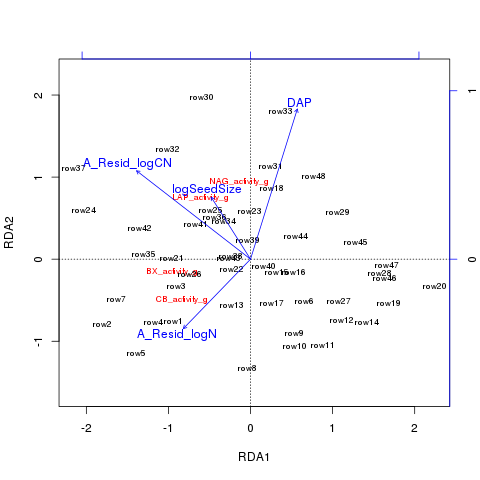

In [54]:
%%R
plot(enz.rda)

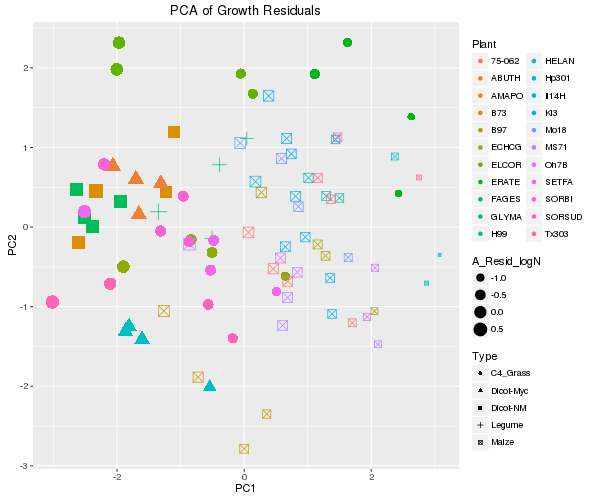

In [147]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sd, S)

p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN, pch = Type))
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [148]:
%%R
data = E_Fit
m = lmer(BX_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("BX_rel") 
        anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(CB_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("CB_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(LAP_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("LAP_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m = lmer(NAG_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("NAG_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print



[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
PC1 155.022 155.022     1 82.458  6.3622 0.01358 *
PC2 168.981 168.981     1 82.091  6.9351 0.01010 *
PC3  54.616  54.616     1 81.595  2.2415 0.13821  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
    Sum Sq Mean Sq NumDF  DenDF F.value    Pr(>F)    
PC1 395.12  395.12     1 83.269  17.491 7.104e-05 ***
PC2  17.42   17.42     1 82.776   0.771    0.3825    
PC3   9.92    9.92     1 82.013   0.439    0.5095    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
    Sum Sq Mean Sq NumDF  DenDF F.value   Pr(>F)   
PC1 2088.9  2088.9     1 81.649  2.7189 0.103008   
PC2 5660

* PC1 correlated with BX and CB
* PC2 correlated with LAP and NAG
* PC3 not significant

### Early season, except FAGES

In [149]:
%%R
head(sd)

             Unique    PlotID Plant Plot Treatment Rep DAP Sampling
1 sample1-1.27_Nneg 1.27_Nneg FAGES 1.27      Nneg   1  36  sample1
2 sample1-2.23_Nneg 2.23_Nneg FAGES 2.23      Nneg   2  36  sample1
3 sample1-3.08_Nneg 3.08_Nneg FAGES 3.08      Nneg   3  36  sample1
4 sample1-4.24_Nneg 4.24_Nneg FAGES 4.24      Nneg   4  36  sample1
5 sample2-1.08_Nneg 1.08_Nneg AMAPO 1.08      Nneg   1  53  sample2
6 sample2-1.24_Nneg 1.24_Nneg ECHCG 1.24      Nneg   1  53  sample2
    PlantSample     Type Grass_Broad Status Subfamily Symbol_class Plant_num
1 FAGES_sample1 Dicot-NM       Dicot   Crop      <NA>           24         4
2 FAGES_sample1 Dicot-NM       Dicot   Crop      <NA>           24         4
3 FAGES_sample1 Dicot-NM       Dicot   Crop      <NA>           24         4
4 FAGES_sample1 Dicot-NM       Dicot   Crop      <NA>           24         4
5 AMAPO_sample2 Dicot-NM       Dicot   Weed      <NA>           24         4
6 ECHCG_sample2 C4_Grass     Monocot   Weed  Paniceae         

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.5677 1.1346 0.50393 0.02963
Proportion of Variance 0.6145 0.3219 0.06349 0.00022
Cumulative Proportion  0.6145 0.9363 0.99978 1.00000
                        PC1        PC2       PC3         PC4
log(SeedSize_mg)  0.5377614 -0.3259685 0.7747826  0.06533897
A_Resid_logN     -0.5414762 -0.4530137 0.2413848 -0.66581937
A_Resid_logCN    -0.1683007  0.8224942 0.4837178 -0.24737667
A_Resid_logB     -0.6239319 -0.1096650 0.3278146  0.70087101


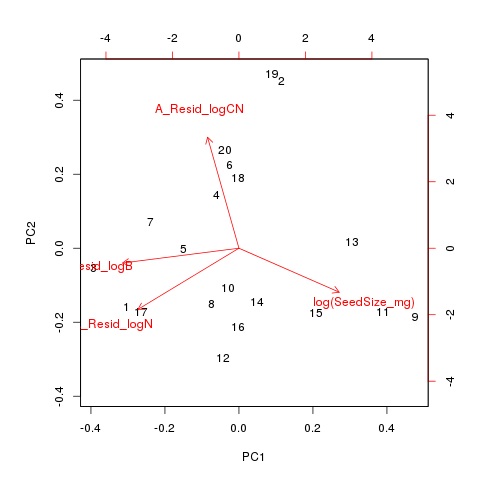

In [150]:
%%R
sd$DAP = as.factor(sd$DAP)
sub_sd = filter(sd, DAP %in% c( "53", "57", "61"))

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = sub_sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

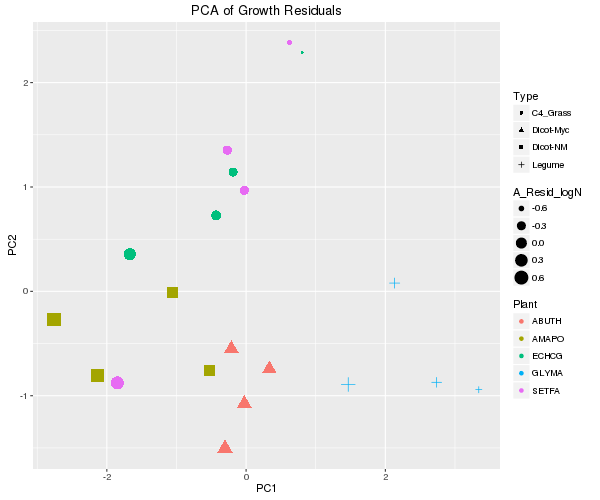

In [151]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sub_sd, S)

p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN, pch = Type))
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [152]:
%%R
data = E_Fit
m = lmer(BX_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("BX_rel") 
        anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(CB_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("CB_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(LAP_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("LAP_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m = lmer(NAG_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("NAG_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print



[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
PC1 112.227 112.227     1 13.585  4.0723 0.06379 .
PC2  15.165  15.165     1 15.114  0.5503 0.46957  
PC3   0.034   0.034     1 13.262  0.0012 0.97264  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
PC1 13.1015 13.1015     1 13.585 0.44879 0.5141
PC2  3.4463  3.4463     1 15.114 0.11805 0.7359
PC3  3.9025  3.9025     1 13.262 0.13368 0.7204
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
PC1  968.50  968.50     1 13.387  1.8376 0.1977
PC2 1505.83 1505.83     1 14.454  2.8571 0.1124
PC3   92.86   92.86     1 13.162  0.1762 0.6814
[1] "NAG_re

* No relation of growth characteristics and enzymes in early season annuals

### Late season annuals and B73

Importance of components:
                          PC1    PC2     PC3     PC4
Standard deviation     1.4973 1.1837 0.59627 0.03612
Proportion of Variance 0.5605 0.3503 0.08888 0.00033
Cumulative Proportion  0.5605 0.9108 0.99967 1.00000
                       PC1         PC2        PC3         PC4
log(SeedSize_mg) 0.5549666 -0.24710822 -0.7936365 -0.03302717
A_Resid_logN     0.4687695  0.59539147  0.1686459 -0.63033538
A_Resid_logCN    0.2340853 -0.76240075  0.4191288 -0.43391266
A_Resid_logB     0.6461202  0.05649449  0.4074687  0.64288904


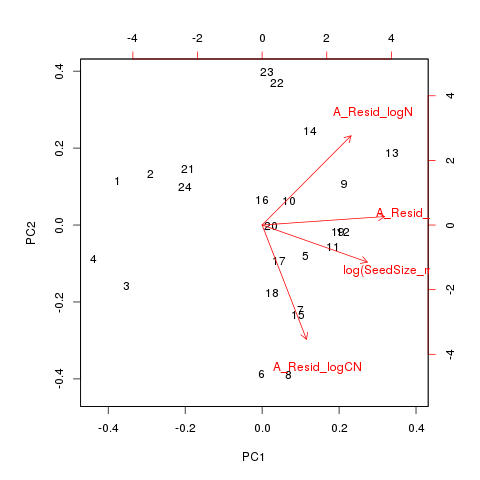

In [153]:
%%R
sd$DAP = as.factor(sd$DAP)
sub_sd = filter(sd, Plant %in% c("B73", "ERATE", 
 "ELCOR",  "SORSUD",    "SORBI", "HELAN"))

fit = prcomp(~log(SeedSize_mg) + A_Resid_logN + A_Resid_logCN + A_Resid_logB, data = sub_sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

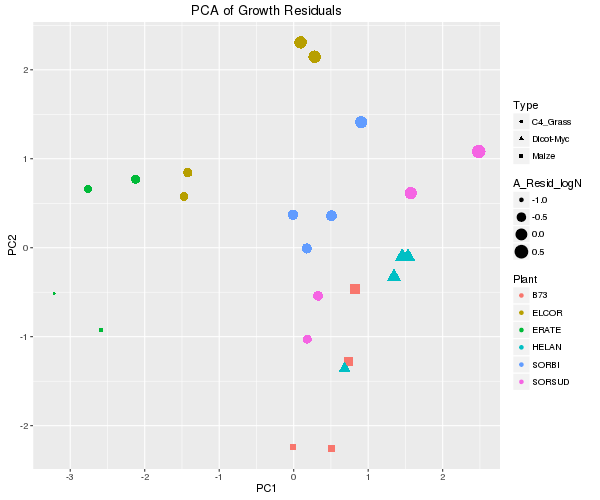

In [154]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sub_sd, S)

p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = A_Resid_logN, pch = Type))
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

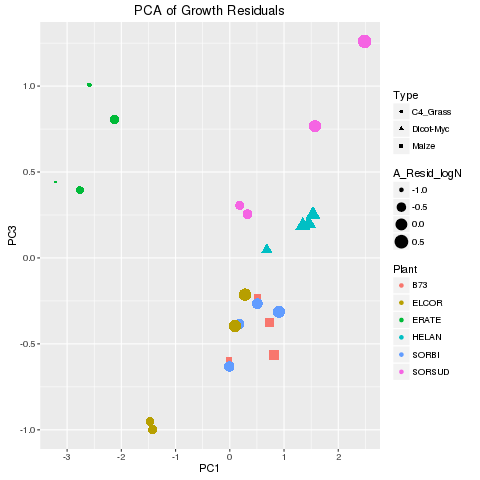

In [155]:
%%R
p = ggplot(E_Fit, aes(PC1, PC3, colour = Plant, 
                       size = A_Resid_logN, pch = Type))
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [157]:
%%R
data = E_Fit
m = lmer(BX_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("BX_activity_g") 
        anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(CB_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("CB_activity_g") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(LAP_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("LAP_activity_g") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m = lmer(NAG_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("NAG_activity_g") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print



[1] "BX_activity_g"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
PC1  60.196  60.196     1 18.683  4.1734 0.05543 .
PC2  63.407  63.407     1 19.989  4.3960 0.04895 *
PC3 104.759 104.759     1 18.432  7.2629 0.01460 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "CB_activity_g"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
PC1 109.496 109.496     1 18.683  5.7761 0.02681 *
PC2   1.753   1.753     1 19.989  0.0925 0.76421  
PC3 108.766 108.766     1 18.432  5.7376 0.02741 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
[1] "LAP_activity_g"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
PC1  997.09  997.09     1 18.018  2.7414 0.11509  
P

* PC1 and PC3 may be significant in late season annuals and PC2 significant for LAP

### Just maize

Importance of components:
                          PC1    PC2    PC3     PC4
Standard deviation     1.4134 1.1975 0.7282 0.19459
Proportion of Variance 0.4994 0.3585 0.1326 0.00947
Cumulative Proportion  0.4994 0.8579 0.9905 1.00000
                         PC1         PC2        PC3         PC4
log(SeedSize_mg)  0.35986596 -0.55923524 -0.7427248 -0.07818144
M_Resid_logN      0.63532037  0.34250526  0.1216591 -0.68136425
M_Resid_logCN    -0.02638971 -0.75308114  0.5856770 -0.29858810
M_Resid_logB      0.68276504 -0.05305549  0.3009011  0.66368333


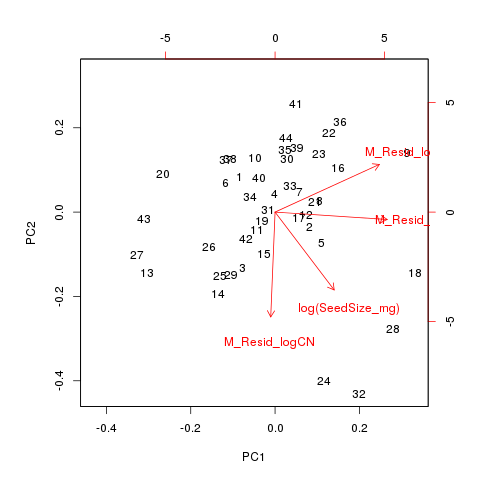

In [158]:
%%R
sd$DAP = as.factor(sd$DAP)
sub_sd = filter(sd, Type == "Maize")

fit = prcomp(~log(SeedSize_mg) + M_Resid_logN + M_Resid_logCN + M_Resid_logB, data = sub_sd, 
                 na.action = na.exclude, center = TRUE, scale = TRUE)

summary(fit) %>% print
fit$rotation %>% print
biplot(fit)

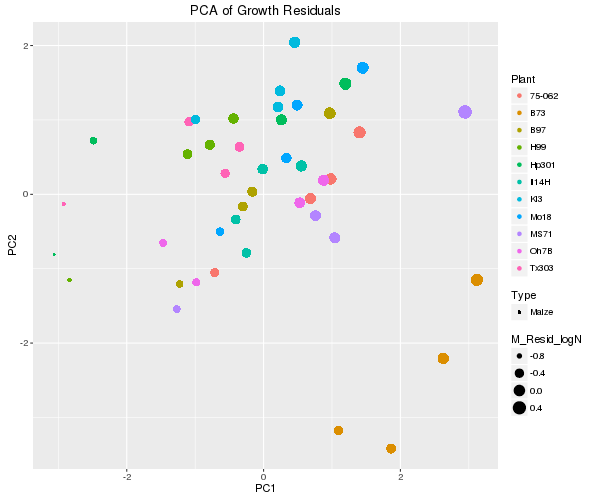

In [159]:
%%R -w 600 -h 500
S = predict(fit)[,1:3]
E_Fit = cbind(sub_sd, S)

p = ggplot(E_Fit, aes(PC1, PC2, colour = Plant, 
                       size = M_Resid_logN, pch = Type))
p = p + geom_point()
#p = p + scale_colour_brewer(palette="Paired")
p = p + ggtitle("PCA of Growth Residuals")
p

In [160]:
%%R
data = E_Fit
m = lmer(BX_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("BX_rel") 
        anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(CB_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("CB_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print

m = lmer(LAP_activity_g ~ PC1 + PC2  + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("LAP_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print
m = lmer(NAG_activity_g ~ PC1 + PC2 + PC3 +
         (1|Rep) , 
          data = data, na.rm = TRUE)
         #summary(m) %>% print
        print("NAG_rel") 
         anova(m, ddf="Kenward-Roger", type=3) %>% print



[1] "BX_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
    Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
PC1  5.125   5.125     1 38.566 0.20087 0.6565
PC2 41.501  41.501     1 38.820 1.62673 0.2097
PC3  1.949   1.949     1 37.375 0.07641 0.7837
[1] "CB_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
PC1  0.1202  0.1202     1 39.149 0.00680 0.9347
PC2 22.4938 22.4938     1 39.435 1.27244 0.2661
PC3  0.3757  0.3757     1 37.554 0.02125 0.8849
[1] "LAP_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
PC1   32.13   32.13     1 37.973 0.02949 0.8646
PC2 1830.37 1830.37     1 38.148 1.68013 0.2027
PC3   32.77   32.77     1 37.222 0.03008 0.8632
[1] "NAG_rel"
Analysis of Variance Table of type III  with  Kenward-Roger 
approximation for d

* Within maize, PC2 is significant for NAG

First, tested model with plant, treatment, plant:treatment, residual SLA, residual logN, residual logB, residual logCN.  Residual logBiomass and logN are colinear, so neither are significant when both are in the model.  Remove log biomass.  logLeafN not significant, remove.  logSLA not significant, remove.  LogCN is more significant when logN is included.  logN is more significant when log CN is included. 
BX_rel ~ Plant + Treatment + Resid_logCN + Resid_logN + Plant:Treatment + (1|Rep) + (1|Rep:Plant). 

Add inorganicN_RE (rhizosphere effect) to parsed down model:
When added residN is still significant, but residLogCN is no longer.  Interestingly, InorganicN_RE is not significant. 

Double checked Inorganic N in case calculation was skewing results.  Still not signficant and has same effect on other terms.  Remove inorganic N from model.  

Residuals are heteroskedastic, log transform.

Interactions of residuals and treatments are not sigificant.  

Best model:
m = lmer(log(BX_rel) ~  Plant + Treatment + Resid_logCN + 
        Resid_logN   + Plant:Treatment + (1|Rep) + (1|Rep:Plant), 
          data = Plant, na.rm = TRUE)

# Try plant function, enzyme and microbial community in one analysis

In [161]:
%%R


              Unique    PlotID  Plant Plot Treatment Rep DAP Sampling
1  sample5-1.16_Nneg 1.16_Nneg    H99 1.16      Nneg   1  72  sample5
2  sample5-1.17_Nneg 1.17_Nneg   MS71 1.17      Nneg   1  72  sample5
3  sample5-1.22_Nneg 1.22_Nneg 75-062 1.22      Nneg   1  72  sample5
4  sample5-1.25_Nneg 1.25_Nneg  Il14H 1.25      Nneg   1  72  sample5
5  sample5-2.06_Nneg 2.06_Nneg   MS71 2.06      Nneg   2  72  sample5
6  sample5-2.11_Nneg 2.11_Nneg    H99 2.11      Nneg   2  72  sample5
7  sample5-2.15_Nneg 2.15_Nneg  Il14H 2.15      Nneg   2  72  sample5
8  sample5-2.29_Nneg 2.29_Nneg 75-062 2.29      Nneg   2  72  sample5
9  sample5-3.13_Nneg 3.13_Nneg   MS71 3.13      Nneg   3  72  sample5
10 sample5-3.16_Nneg 3.16_Nneg    H99 3.16      Nneg   3  72  sample5
11 sample5-3.17_Nneg 3.17_Nneg  Il14H 3.17      Nneg   3  72  sample5
12 sample5-3.27_Nneg 3.27_Nneg 75-062 3.27      Nneg   3  72  sample5
13 sample5-4.05_Nneg 4.05_Nneg    H99 4.05      Nneg   4  72  sample5
14 sample5-4.08_Nneg

Notes:
Follows similar pattern as BX except log transformation may not be necessary.  
If Plant:Treatment is removed InorganicN_RE is marginally significant, but not when Plant is removed

# Sandbox

# Nitrogen nutrition index and enzyme activity

In [39]:
%%R
#Creat variables
# W, tons/ha
    Plant$W <- Plant$Biomass_P/17.391

#Subset to just maize
    Maize = filter(Plant, Type == "Maize")
#Create critical N (Nc) variable
    Maize$Nc <- 3.40*Maize$W^-0.37
    Maize$NNI <- Maize$Plant_N/Maize$Nc

### Plot %N by W

In [40]:
%%R
colnames(Maize)

 [1] "Unique"             "PlotID"             "Plant"             
 [4] "Plot"               "Treatment"          "Rep"               
 [7] "DAP"                "Sampling"           "PlantSample"       
[10] "Type"               "Grass_Broad"        "Status"            
[13] "Subfamily"          "Symbol_class"       "Plant_num"         
[16] "Leaf_AreaBiomass_g" "Biomass_T"          "Biomass_P"         
[19] "Leaf_Area_cm2"      "SLA"                "Leaf_N"            
[22] "Leaf_C"             "LeafC_N"            "LNa"               
[25] "Plant_N"            "Plant_C"            "Plant_CN"          
[28] "d15N"               "tN_p"               "BX_act"            
[31] "CB_act"             "LAP_act"            "NAG_act"           
[34] "soil_dw"            "BX_activity_g"      "CB_activity_g"     
[37] "LAP_activity_g"     "NAG_activity_g"     "BX_barefactor"     
[40] "CB_barefactor"      "LAP_barefactor"     "NAG_barefactor"    
[43] "BX_dif"             "CB_dif"             "

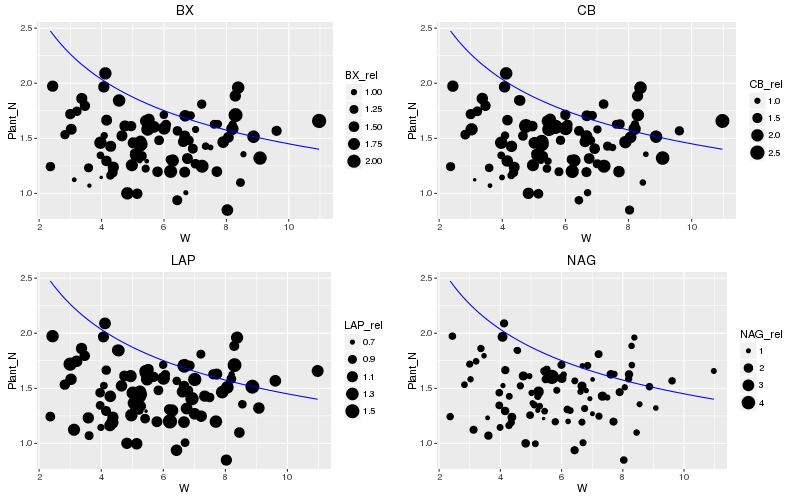

In [41]:
%%R -w 800 -h 500
CriticalN <- function(x) {3.40*x^-0.37}


p = ggplot(Maize, aes(W, Plant_N))
p = p + geom_point(aes(size = BX_rel))
p = p + stat_function(fun = CriticalN, col = "blue")
p = p + ggtitle("BX")


p1 = ggplot(Maize, aes(W, Plant_N))
p1 = p1 + geom_point(aes(size = CB_rel))
p1 = p1 + stat_function(fun = CriticalN, col = "blue")
p1 = p1 + ggtitle("CB")
 

p2 = ggplot(Maize, aes(W, Plant_N))
p2 = p2 + geom_point(aes(size = LAP_rel))
p2 = p2 + stat_function(fun = CriticalN, col = "blue")
p2 = p2 + ggtitle("LAP")
 

p3 = ggplot(Maize, aes(W, Plant_N))
p3 = p3 + geom_point(aes(size = NAG_rel))
p3 = p3 + stat_function(fun = CriticalN, col = "blue")
p3 = p3 + ggtitle("NAG")

grid.arrange(p, p1, p2, p3, ncol = 2)

### Model rel enzyme effect by NNI

In [42]:
%%R
str(anova(fit1)) %>% print
anova(fit1)


Error in anova(fit1) : object 'fit1' not found


/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Error in anova(fit1) : object 'fit1' not found

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: In addition: 
  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Warning messages:

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 1: extra argument(s) ‘na.rm’ disregarded 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 2: extra argument(s) ‘na.rm’ disregarded 

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: User

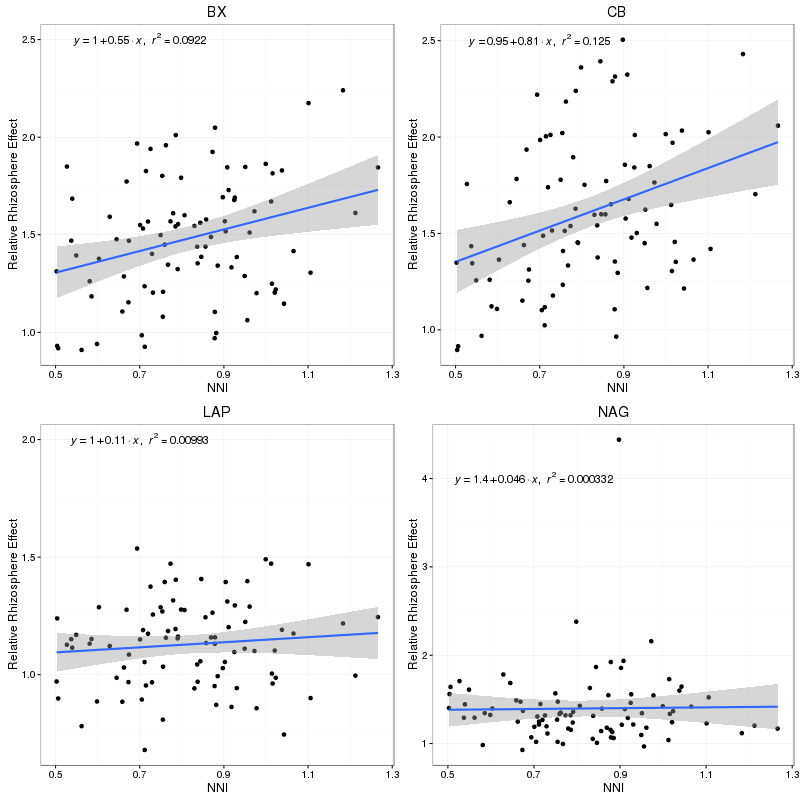

In [43]:
%%R -w 800 -h 800
lm_eqn <- function(m){
    eq <- substitute(italic(y) == a + b %.% italic(x)* 
                     ","~~italic(r)^2~"="~r2, 
         list(a = format(coef(m)[1], digits = 2), 
              b = format(coef(m)[2], digits = 2),
             r2 = format(summary(m)$r.squared, digits = 3)))
    as.character(as.expression(eq));                 
}

#define subset of data
Mdata = Maize
#Mdata = filter(Maize, Treatment == "Nneg")

fit = lm(BX_rel~NNI, data = Mdata)
fit1 = lm(CB_rel~NNI, data = Mdata)
fit2 = lm(LAP_rel~NNI, data = Mdata)
fit3 = lm(NAG_rel~NNI, data = Mdata)

p = ggplot()
p = p + theme_bw()
p = p + ylab("Relative Rhizosphere Effect")
p = p + xlab("NNI")
p = p + ggtitle("BX")
p = p + geom_point(data = Mdata, aes(NNI, BX_rel))
p = p + stat_smooth(data = Mdata, method = "lm", 
                aes(x = NNI, y = BX_rel), 
                formula = y ~ x, size = 1, na.rm = TRUE)
p =  p + geom_text(aes(x = .7, y = 2.5), label = lm_eqn(fit), parse = TRUE)


p1 = ggplot()
p1 = p1 + theme_bw()
p1 = p1 + ylab("Relative Rhizosphere Effect")
p1 = p1 + xlab("NNI")
p1 = p1 + ggtitle("CB")
p1 = p1 + geom_point(data = Mdata, aes(NNI, CB_rel))
p1 = p1 + stat_smooth(data = Mdata, method = "lm", 
                aes(x = NNI, y = CB_rel), 
                formula = y ~ x, size = 1, na.rm = TRUE)
p1 =  p1 + geom_text(aes(x = .7, y = 2.5), label = lm_eqn(fit1), parse = TRUE)
p1
           
p2 = ggplot()
p2 = p2 + theme_bw()
p2 = p2 + ylab("Relative Rhizosphere Effect")
p2 = p2 + xlab("NNI")
p2 = p2 + ggtitle("LAP")
p2 = p2 + geom_point(data = Mdata, aes(NNI, LAP_rel))
p2 = p2 + stat_smooth(data = Mdata, method = "lm", 
                aes(x = NNI, y = LAP_rel), 
                formula = y ~ x, size = 1, na.rm = TRUE)
p2 =  p2 + geom_text(aes(x = .7, y = 2.0), label = lm_eqn(fit2), parse = TRUE)

p3 = ggplot()
p3 = p3 + theme_bw()
p3 = p3 + ylab("Relative Rhizosphere Effect")
p3 = p3 + xlab("NNI")
p3 = p3 + ggtitle("NAG")
p3 = p3 + geom_point(data = Mdata, aes(NNI, NAG_rel))
p3 = p3 + stat_smooth(data = Mdata, method = "lm", 
                aes(x = NNI, y = NAG_rel), 
                formula = y ~ x, size = 1, na.rm = TRUE)
p3 =  p3 + geom_text(aes(x = .7, y = 4), label = lm_eqn(fit3), parse = TRUE)
p3
grid.arrange(p, p1, p2, p3, ncol = 2)

### Best models

Notes: 
    * Enzyme_rel~NNI + Treatment + (1|Rep) + (1|Plant) + (1|Rep:Plant), data = Maize 
        * 1|Plant contains no variance
        * When treatment is in the model NNI is not significant
        * Also true when analyizing activity_g
        * adding interaction term: 
         - BX:no terms significant 
         - CB: Treatment and NNI signifcant, interaction not
         - LAP: NNI significant, interaction significant at .08
         - NAG: no terms significant
         
   * Enzyme_rel~NNI + (1|Rep) + (1|Plant) + (1|Rep:Plant), data = Maize 
       - BX and CB: NNI highly significant, not significant for LAP and NAG


In [94]:
%%R
# Stepwise Regression
library(MASS)
data = Maize
fit <- lm(BX_activity_g~DAP + NNI + M_Resid_logN + M_Resid_logB + M_Resid_logCN + Treatment, data=data)
step <- stepAIC(fit, direction="backward")
step$anova # display results

Start:  AIC=285.85
BX_activity_g ~ DAP + NNI + M_Resid_logN + M_Resid_logB + M_Resid_logCN + 
    Treatment

                Df Sum of Sq    RSS    AIC
- M_Resid_logN   1     2.055 1891.1 283.94
- M_Resid_logB   1     3.101 1892.1 283.99
- NNI            1     4.816 1893.8 284.07
- M_Resid_logCN  1     5.040 1894.0 284.08
<none>                       1889.0 285.85
- Treatment      1    47.226 1936.2 286.02
- DAP            2   259.078 2148.1 293.16

Step:  AIC=283.94
BX_activity_g ~ DAP + NNI + M_Resid_logB + M_Resid_logCN + Treatment

                Df Sum of Sq    RSS    AIC
- NNI            1     5.665 1896.7 282.21
- M_Resid_logB   1     8.706 1899.8 282.35
- M_Resid_logCN  1     9.070 1900.1 282.37
<none>                       1891.1 283.94
- Treatment      1    45.249 1936.3 284.03
- DAP            2   266.204 2157.3 291.54

Step:  AIC=282.21
BX_activity_g ~ DAP + M_Resid_logB + M_Resid_logCN + Treatment

                Df Sum of Sq    RSS    AIC
- M_Resid_logB   1      5.87 19

In [99]:
%%R
# Stepwise Regression
library(MASS)
data = Maize
fit <- lm(CB_activity_g~DAP + NNI + M_Resid_logN + M_Resid_logB + M_Resid_logCN + Treatment, data=data)
step <- stepAIC(fit, direction="backward")
step$anova # display results


Start:  AIC=268.75
CB_activity_g ~ DAP + NNI + M_Resid_logN + M_Resid_logB + M_Resid_logCN + 
    Treatment

                Df Sum of Sq    RSS    AIC
- M_Resid_logCN  1     1.002 1556.5 266.81
- M_Resid_logB   1     4.448 1559.9 267.00
- M_Resid_logN   1     6.918 1562.4 267.14
- NNI            1    18.595 1574.1 267.80
<none>                       1555.5 268.75
- DAP            2    96.569 1652.0 270.05
- Treatment      1    71.001 1626.5 270.68

Step:  AIC=266.81
CB_activity_g ~ DAP + NNI + M_Resid_logN + M_Resid_logB + Treatment

               Df Sum of Sq    RSS    AIC
- NNI           1    20.696 1577.2 265.97
- M_Resid_logN  1    33.274 1589.8 266.67
<none>                      1556.5 266.81
- M_Resid_logB  1    35.923 1592.4 266.82
- DAP           2    97.010 1653.5 268.13
- Treatment     1    80.080 1636.6 269.23

Step:  AIC=265.97
CB_activity_g ~ DAP + M_Resid_logN + M_Resid_logB + Treatment

               Df Sum of Sq    RSS    AIC
- M_Resid_logB  1    27.863 1605.0 265.51

In [96]:
%%R
# Stepwise Regression
library(MASS)
data = Maize
fit <- lm(LAP_activity_g~DAP + NNI + M_Resid_logN + M_Resid_logB + M_Resid_logCN + Treatment, data=data)
step <- stepAIC(fit, direction="backward")
step$anova # display results


Start:  AIC=606.79
LAP_activity_g ~ DAP + NNI + M_Resid_logN + M_Resid_logB + M_Resid_logCN + 
    Treatment

                Df Sum of Sq    RSS    AIC
- M_Resid_logN   1        31  72493 604.82
- M_Resid_logB   1        66  72528 604.87
- Treatment      1       130  72592 604.94
- M_Resid_logCN  1       197  72659 605.02
- NNI            1       548  73010 605.45
<none>                        72462 606.79
- DAP            2     32577 105039 635.46

Step:  AIC=604.82
LAP_activity_g ~ DAP + NNI + M_Resid_logB + M_Resid_logCN + Treatment

                Df Sum of Sq    RSS    AIC
- Treatment      1       107  72600 602.95
- M_Resid_logB   1       497  72990 603.43
- NNI            1       588  73081 603.54
- M_Resid_logCN  1       892  73386 603.90
<none>                        72493 604.82
- DAP            2     32547 105040 633.46

Step:  AIC=602.95
LAP_activity_g ~ DAP + NNI + M_Resid_logB + M_Resid_logCN

                Df Sum of Sq    RSS    AIC
- M_Resid_logB   1       467  7306

In [101]:
%%R
fit <- lm(LAP_activity_g ~ DAP + M_Resid_logCN, data=data)
anova(fit)

Analysis of Variance Table

Response: LAP_activity_g
              Df Sum Sq Mean Sq F value    Pr(>F)    
DAP            2  32885 16442.3 18.8828 1.689e-07 ***
M_Resid_logCN  1   1830  1830.2  2.1019    0.1508    
Residuals     84  73143   870.8                      
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In [70]:
%%R
str(step)

List of 15
 $ coefficients : Named num [1:15] 0.756 0.17 0.397 0.168 0.491 ...
  ..- attr(*, "names")= chr [1:15] "(Intercept)" "PlantB73" "PlantB97" "PlantH99" ...
 $ residuals    : Named num [1:88] -0.0885 -0.2052 -0.2745 -0.1134 -0.4765 ...
  ..- attr(*, "names")= chr [1:88] "1" "2" "3" "4" ...
 $ effects      : Named num [1:88] -13.8926 -0.4008 -0.2717 0.0439 -0.2736 ...
  ..- attr(*, "names")= chr [1:88] "(Intercept)" "PlantB73" "PlantB97" "PlantH99" ...
 $ rank         : int 15
 $ fitted.values: Named num [1:88] 1.41 1.64 1.26 1.5 1.39 ...
  ..- attr(*, "names")= chr [1:88] "1" "2" "3" "4" ...
 $ assign       : int [1:15] 0 1 1 1 1 1 1 1 1 1 ...
 $ qr           :List of 5
  ..$ qr   : num [1:88, 1:15] -9.381 0.107 0.107 0.107 0.107 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:88] "1" "2" "3" "4" ...
  .. .. ..$ : chr [1:15] "(Intercept)" "PlantB73" "PlantB97" "PlantH99" ...
  .. ..- attr(*, "assign")= int [1:15] 0 1 1 1 1 1 1 1 1 1 ...
  .. ..- attr(*, "contras

In [62]:
%%R
data = filter(Maize,  Treatment == "Nneg")
fit1 = lmer(BX_rel~ NNI  + (1|Rep), data = data)
anova(fit1) %>% print

fit2 = lmer(CB_rel~ NNI  + (1|Rep) , data = data)
anova(fit2) %>% print

fit3 = lmer(LAP_rel~ NNI +   (1|Rep)  , data = data)
anova(fit3) %>% print

fit4 = lmer(NAG_rel~NNI   +  (1|Rep)  , data = data)
anova(fit4) %>% print

Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value Pr(>F)
NNI 0.12714 0.12714     1 39.882  1.5025 0.2275
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF DenDF F.value  Pr(>F)  
NNI 0.54779 0.54779     1    42  5.2941 0.02643 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
NNI 0.12615 0.12615     1 41.923  3.1547 0.08297 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
Analysis of Variance Table of type III  with  Satterthwaite 
approximation for degrees of freedom
     Sum Sq Mean Sq NumDF  DenDF F.value  Pr(>F)  
NNI 0.22578 0.22578     1 41.655  5.9792 0.01879 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


* Notes  lm(Enzyme_rel~NNI, data = Maize)
    - adjusted R2 from lm(Enzyme_rel~NNI, data = Maize)
        * BX: .08
        * CB: .11
        * LAP: 0
        * NAG: 0
    - adjusted R2 from lm(Enzyme_rel~Treatment, data = Maize)
        * BX: .1347
        * CB: .2104
        * LAP: 0
        * NAG: .064
            
Conclusion: plants with higher NNI have higher CB and BX rhizosphere effect, but simple N treatment model is actually a better predictor

In [45]:
%%R

fit1 = lm(BX_rel~Treatment, data = Maize)
summary(fit1) %>% print

fit2 = lm(CB_rel~Treatment, data = Maize)
summary(fit2) %>% print

fit3 = lm(LAP_rel~Treatment, data = Maize)
summary(fit3) %>% print

fit4 = lm(NAG_rel~Treatment, data = Maize)
summary(fit4) %>% print


Call:
lm(formula = BX_rel ~ Treatment, data = Maize)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.62783 -0.19919 -0.01383  0.19721  0.64695 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.36415    0.04331  31.498  < 2e-16 ***
TreatmentNpos  0.23360    0.06125   3.814 0.000257 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.2873 on 86 degrees of freedom
Multiple R-squared:  0.1447,	Adjusted R-squared:  0.1347 
F-statistic: 14.55 on 1 and 86 DF,  p-value: 0.0002567


Call:
lm(formula = CB_rel ~ Treatment, data = Maize)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6831 -0.2481 -0.0579  0.2203  0.8117 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.42797    0.05206  27.430  < 2e-16 ***
TreatmentNpos  0.36200    0.07362   4.917 4.17e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.